# CycleGAN

> CycleGAN in fastai

- toc: true
- badges: true
- comments: true
- author: Isaac Flath
- categories: [Deep Learning]
- hide: true

In this post I will build on my previous posts on GANs and actually train a CycleGAN model.  There's a few tricks and core elements to making it work which I will discuss as we go.  Two of the most important things to note upfront are:

1. There are 2 generators and 2 discriminators being trained
1. The loss function adds a special component which adds the full cycle to the loss function (ie Horse -> generator -> Zebra -> generator -> Horse -> How close is this generated horse to starting horse)

So let's get started!

>Note: I am basing this off of a great [Pytorch Cycle GAN implementation](https://github.com/aitorzip/PyTorch-CycleGAN).  What is being done is basically identical, I just did some refactoring and explaining.

# Models

In [1]:
from fastai.vision.all import *
from fastcore.basics import *


# import itertools
# import glob
# import random
# import os
import torchvision.transforms as transforms
# from torch.utils.data import DataLoader
from torch.autograd import Variable
# from PIL import Image
# import torch
# import sys
# from torchvision.utils import save_image
from torch.utils.data import Dataset
import datetime

In [2]:
# !mkdir -p ./datasets
# !wget -N https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/summer2winter_yosemite.zip -O ./datasets/summer2winter_yosemite.zip
# !unzip ./datasets/summer2winter_yosemite.zip -d ./datasets/

First, I define some hyper parameters.  This came directly from the repository mentioned above.  I increased the batch sizem but otherwise left it all the same.

In [3]:
opt = AttrDict()
opt['epoch']=0
opt['n_epochs']=200
opt['batchSize']=4 #1
opt['dataroot']='datasets/summer2winter_yosemite/'
opt['lr']=0.0002
opt['decay_epoch']=100
opt['size']=256
opt['input_nc']=3
opt['output_nc']=3
opt['n_cpu']=8
opt['cuda']=True

# Dataset

Next we create our dataset and dataloaders.  As you can see, it's a bit different from others.  There are no labels as we are used to, and it returns images divided by the class.

In [4]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, 'trainA') + '/*.*'))[:100]
        self.files_B = sorted(glob.glob(os.path.join(root, 'trainB') + '/*.*'))[:100]
    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))
    
    
    def show_batch(self,sets=2, cols=3):
        idxs = random.sample(range(self.__len__()), cols*2*sets)        
        fig, ax = plt.subplots(2*sets, cols,figsize=(4*cols,5*2*sets))
        
        for r in range(sets):
            for col in range(0,cols):
                row=r*2
                num = (row * cols + col)
                x = self[idxs[num]]['A'].permute(1,2,0)
                ax[row,col].imshow(x)
                ax[row,col].get_xaxis().set_visible(False)
                ax[row,col].get_yaxis().set_visible(False)

                row=row+1
                num = (row * cols + col)
                x = self[idxs[num]]['B'].permute(1,2,0)
                ax[row,col].imshow(x)           
                ax[row,col].get_xaxis().set_visible(False)
                ax[row,col].get_yaxis().set_visible(False)
            
        

In [5]:
# Dataset loader
transforms_ = [ transforms.Resize(int(opt.size*1.12), Image.BICUBIC), 
                transforms.RandomCrop(opt.size), 
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset(opt.dataroot, transforms_=transforms_, unaligned=True),batch_size=opt.batchSize, shuffle=True, num_workers=opt.n_cpu)

Let's take a look at some images so we know what we are trying to do and know that our dataloaders works right.  The 1st and 3rd row are class 'A' and the 2nd and 4th rows are class 'B'. You may notice we are turning summer pictures of yosimite and winterizing them.

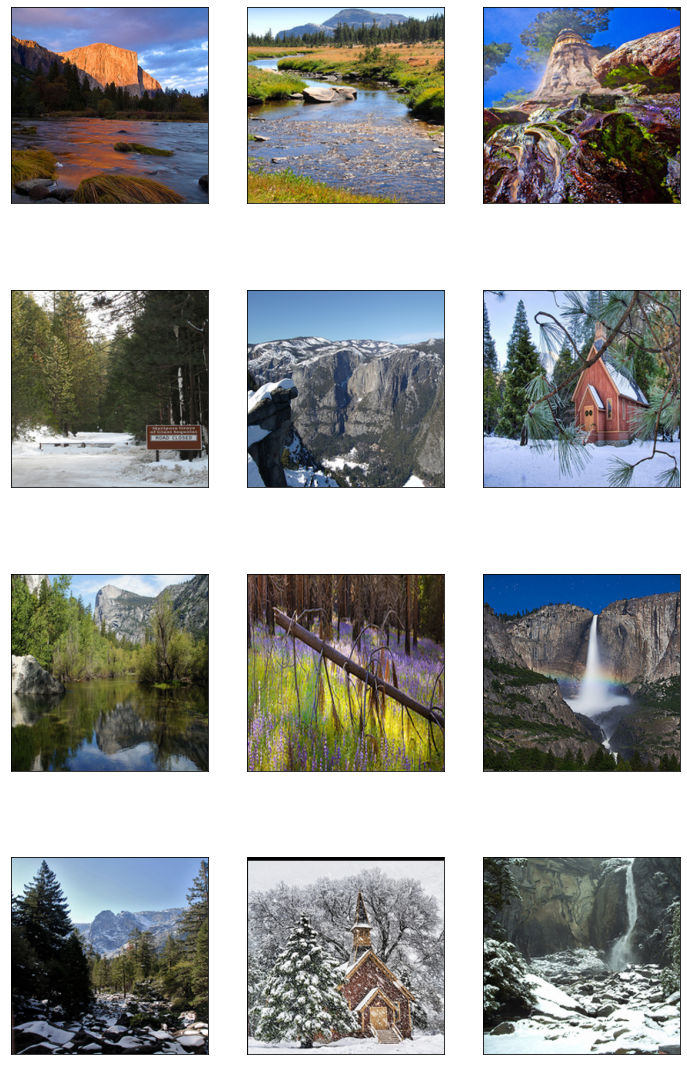

In [6]:
dset = ImageDataset(opt.dataroot, transforms_=transforms_[:-1], unaligned=True)

dset.show_batch()

# Scheduler

In [7]:
#hide
class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0)
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

Here we define our scheduler. We will be using this for the Generators and Discriminators.  The decay doesn't kick in immediately,

In [8]:
class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

And the schedulers and optimizers below.  D_A is the discriminator for A, where G is for generator.

In [9]:
# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(A2B_model.generator.parameters(), B2A_model.generator.parameters()),lr=opt.lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(B2A_model.critic.parameters(), lr=opt.lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(A2B_model.critic.parameters(), lr=opt.lr, betas=(0.5, 0.999))
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)

NameError: name 'A2B_model' is not defined

# Initialization

Function for initializing weights using a normal distribution

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

# Models

Finally, we define our models.  If you recall there will be 2 generators and 2 discriminators.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [ ]:
def disc_block(in_channels,out_channels,kernel_size=4,stride=2):
    return [  nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=1),
                nn.InstanceNorm2d(out_channels), 
                nn.LeakyReLU(0.2, inplace=True) ]

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += disc_block(64,128)
        model += disc_block(128,256)
        model += disc_block(256,512,4,1)
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

I put these in a simple class.  This way they go together.  The Generator that Generates Image A is paired in the same module as the Discriminator on Image A.  This is just to make things a bit cleaner.

In [ ]:
class GANModule(Module):
    def __init__(self, generator=None, critic=None):
        self.generator=generator
        self.critic   =critic
        self.critic.cuda()
        self.generator.cuda()
        self.critic.apply(weights_init_normal)
        self.generator.apply(weights_init_normal)

In [ ]:
A2B_model = GANModule(generator=Generator(opt.input_nc, opt.output_nc),critic=Discriminator(opt.output_nc))
B2A_model = GANModule(generator=Generator(opt.output_nc, opt.input_nc),critic=Discriminator(opt.input_nc))

# Loss Functions

The loss functions are the most interesting part of cycle gan.  There's three main components:

+ criterion_GAN:  This is standard MSE Loss.  This is the most straightforward loss.  We take the predictions by the critic and the truth of whether the image was generated or real.  This is for the Critic.
+ criterion_cycle: This is where cycleGAN gets it's name.  L1 loss is just trying to minimize the difference in pixel values.  But how does it have images to compare when it's an unpaired dataset?
    + Start with class A and run your Generator to create class B out of the Class A image
    + Take that class B image that was just generated, and run it through the other generator to create a class A image
    + If all you are doing is transferring styles you should get the exact same image back.  Those are the 2 images being compared.
+ criterion_identity:  This is also L1Loss but is putting in real images and comparing them with generated images rather than doing the entire cycle.

In [ ]:
# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Final Setup

We are creating some tensors we will be using.  We can create and re-use our targets for example because if we generate a batch of images we know they are all fake.  

In [ ]:
# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor
input_A = Tensor(opt.batchSize, opt.input_nc, opt.size, opt.size)
input_B = Tensor(opt.batchSize, opt.output_nc, opt.size, opt.size)
target_real = Variable(Tensor(opt.batchSize).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(opt.batchSize).fill_(0.0), requires_grad=False)

In [ ]:
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [ ]:
time_tracker = datetime.datetime.now()

# Training

First, we define a few functions to simplify things.  Because we have 2 generators and 2 critics, there was a lot of duplicate code.  Refactoring makes it easier to understand.  SO what's going on?

Generator:
+ Calculating the losses for all three types
+ Generating fake images (the critic needs theses)

Critic:
+ Making predictions on real and fake images
+ Calculating loss and completing backprog

In [ ]:
def generator_batch(real,target,model1,model2):
    same = model2.generator(real)# identity loss

    loss_identity = criterion_identity(same, real)*5.0
    fake = model1.generator(real)# GAN loss = netG_a2B
    
    pred_fake = model1.critic(fake)
    loss_GAN = criterion_GAN(pred_fake, target)
    
    recovered = model2.generator(fake) #cycle loss
    loss_cycle = criterion_cycle(recovered, real)*10.0
    
    return loss_identity,loss_GAN,loss_cycle,fake

def critic_batch(real, fake, target_real, target_fake, buffer, optimizer, model):

    optimizer.zero_grad()
    pred_real = model.critic(real)
    loss_D_real = criterion_GAN(pred_real, target_real)
    fake = buffer.push_and_pop(fake_A)
    pred_fake = model.critic(fake.detach())
    loss_D_fake = criterion_GAN(pred_fake, target_fake)
    loss_D = (loss_D_real + loss_D_fake)*0.5
    loss_D.backward()
    optimizer.step()

We put this in a training loop and away we go!

In [ ]:
###### Training ######
time_tracker = datetime.datetime.now()
for epoch in range(opt.epoch, opt.n_epochs):
    print(f'epoch={epoch} | elapsed={str(datetime.datetime.now() - time_tracker)}  | time={str(datetime.datetime.now())}')
    time_tracker = datetime.datetime.now()

    time_tracker = datetime.datetime.now()

    for i, batch in enumerate(dataloader):
        # Set model input
        real_A = Variable(input_A.copy_(batch['A']))
        real_B = Variable(input_B.copy_(batch['B']))

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()
        loss_identity_A, loss_GAN_A2B, loss_cycle_ABA,fake_B = generator_batch(real_A,target_real,A2B_model,B2A_model)
        loss_identity_B, loss_GAN_B2A, loss_cycle_BAB,fake_A = generator_batch(real_B,target_real,B2A_model,A2B_model)
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        optimizer_G.step()

        ###### Discriminators ######
        critic_batch(real_A, fake_A, target_real, target_fake, fake_A_buffer, optimizer_D_A, B2A_model)
        critic_batch(real_B, fake_B, target_real, target_fake, fake_A_buffer, optimizer_D_B, A2B_model)

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
    # Save models checkpoints
    torch.save(A2B_model.generator.state_dict(), 'output/netG_A2B.pth')
    torch.save(B2A_model.generator.state_dict(), 'output/netG_B2A.pth')
    torch.save(B2A_model.critic.state_dict(), 'output/netD_A.pth')
    torch.save(A2B_model.critic.state_dict(), 'output/netD_B.pth')

# Testing

In [ ]:


opt = AttrDict()
opt['batchSize']=1 
opt['dataroot']='datasets/summer2winter_yosemite/'
opt['input_nc']=3
opt['output_nc']=3
opt['size']=256
opt['cuda']=True
opt['n_cpu']=8
# parser.add_argument('--generator_A2B', type=str, default='output/netG_A2B.pth', help='A2B generator checkpoint file')
# parser.add_argument('--generator_B2A', type=str, default='output/netG_B2A.pth', help='B2A generator checkpoint file')
# opt = parser.parse_args()
print(opt)

# if torch.cuda.is_available() and not opt.cuda:
#     print("WARNING: You have a CUDA device, so you should probably run with --cuda")

###### Definition of variables ######
# Networks
# netG_A2B = Generator(opt.input_nc, opt.output_nc)
# netG_B2A = Generator(opt.output_nc, opt.input_nc)

# if opt.cuda:
#     netG_A2B.cuda()
#     netG_B2A.cuda()

# # Load state dicts
# netG_A2B.load_state_dict(torch.load(opt.generator_A2B))
# netG_B2A.load_state_dict(torch.load(opt.generator_B2A))

# Set model's test mode
netG_A2B.eval()
netG_B2A.eval()

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if opt.cuda else torch.Tensor
input_A = Tensor(opt.batchSize, opt.input_nc, opt.size, opt.size)
input_B = Tensor(opt.batchSize, opt.output_nc, opt.size, opt.size)

# Dataset loader
transforms_ = [ transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset(opt.dataroot, transforms_=transforms_, mode='test'), 
                        batch_size=opt.batchSize, shuffle=False, num_workers=opt.n_cpu)

###### Testing######

# Create output dirs if they don't exist
if not os.path.exists('output/A'): os.makedirs('output/A')
if not os.path.exists('output/B'): os.makedirs('output/B')

for i, batch in enumerate(dataloader):
    real_A = Variable(input_A.copy_(batch['A']))    # Set model input
    fake_B = 0.5*(netG_A2B(real_A).data + 1.0) # Generate output
    save_image(fake_B, 'output/B/%04d.png' % (i+1))
    
    
    real_B = Variable(input_B.copy_(batch['B']))
    fake_A = 0.5*(netG_B2A(real_B).data + 1.0)
    save_image(fake_A, 'output/A/%04d.png' % (i+1))

    sys.stdout.write('\rGenerated images %04d of %04d' % (i+1, len(dataloader)))

sys.stdout.write('\n')